# AIOps Demonstration Notebook


In [115]:
# Step 1: Setup Environment
!pip install numpy pandas matplotlib seaborn scikit-learn statsmodels


[notice] A new release of pip available: 22.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [116]:
# Step 2: Load and Explore Data
import pandas as pd
import numpy as np

# Load your datasets
server_metrics = pd.read_csv("data/netflix_operational_metrics.csv")
business_metrics = pd.read_csv("data/netflix_business_metrics.csv")

# Display basic information and statistics
print(server_metrics.info())
print(server_metrics.describe())

print(business_metrics.info())
print(business_metrics.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Timestamp                      10080 non-null  object 
 1   CPU Utilization (%)            10080 non-null  float64
 2   Memory Utilization (%)         10080 non-null  float64
 3   Network I/O Throughput (Mbps)  10080 non-null  float64
 4   Disk I/O Throughput (MB/s)     10080 non-null  float64
 5   Server Configuration           10080 non-null  object 
dtypes: float64(4), object(2)
memory usage: 472.6+ KB
None
       CPU Utilization (%)  Memory Utilization (%)  \
count         10080.000000            10080.000000   
mean             69.975567               60.169587   
std              10.973602               10.675025   
min               0.000000                0.000000   
25%              62.757592               53.102970   
50%              69.894974   

In [117]:
# Step 3: Data Preprocessing

# Fill missing values with the mean for numeric columns, preserving the Timestamp column
server_metrics_numeric = server_metrics.select_dtypes(include="number").fillna(
    server_metrics.select_dtypes(include="number").mean()
)
server_metrics_non_numeric = server_metrics.select_dtypes(exclude="number")
server_metrics = pd.concat([server_metrics_non_numeric, server_metrics_numeric], axis=1)

business_metrics_numeric = business_metrics.select_dtypes(include="number").fillna(
    business_metrics.select_dtypes(include="number").mean()
)
business_metrics_non_numeric = business_metrics.select_dtypes(exclude="number")
business_metrics = pd.concat(
    [business_metrics_non_numeric, business_metrics_numeric], axis=1
)

# Print columns to ensure 'Timestamp' is preserved
print("Server Metrics Columns After Preprocessing:")
print(server_metrics.columns)

print("Business Metrics Columns After Preprocessing:")
print(business_metrics.columns)

print("Data Preprocessing Completed.")

Server Metrics Columns After Preprocessing:
Index(['Timestamp', 'Server Configuration', 'CPU Utilization (%)',
       'Memory Utilization (%)', 'Network I/O Throughput (Mbps)',
       'Disk I/O Throughput (MB/s)'],
      dtype='object')
Business Metrics Columns After Preprocessing:
Index(['Timestamp', 'Server Configuration', 'Response Time (ms)',
       'Customer Satisfaction (CSAT)', 'Operational Costs ($)',
       'Service Uptime (%)'],
      dtype='object')
Data Preprocessing Completed.


Silhouette Score: 0.16691876406683467


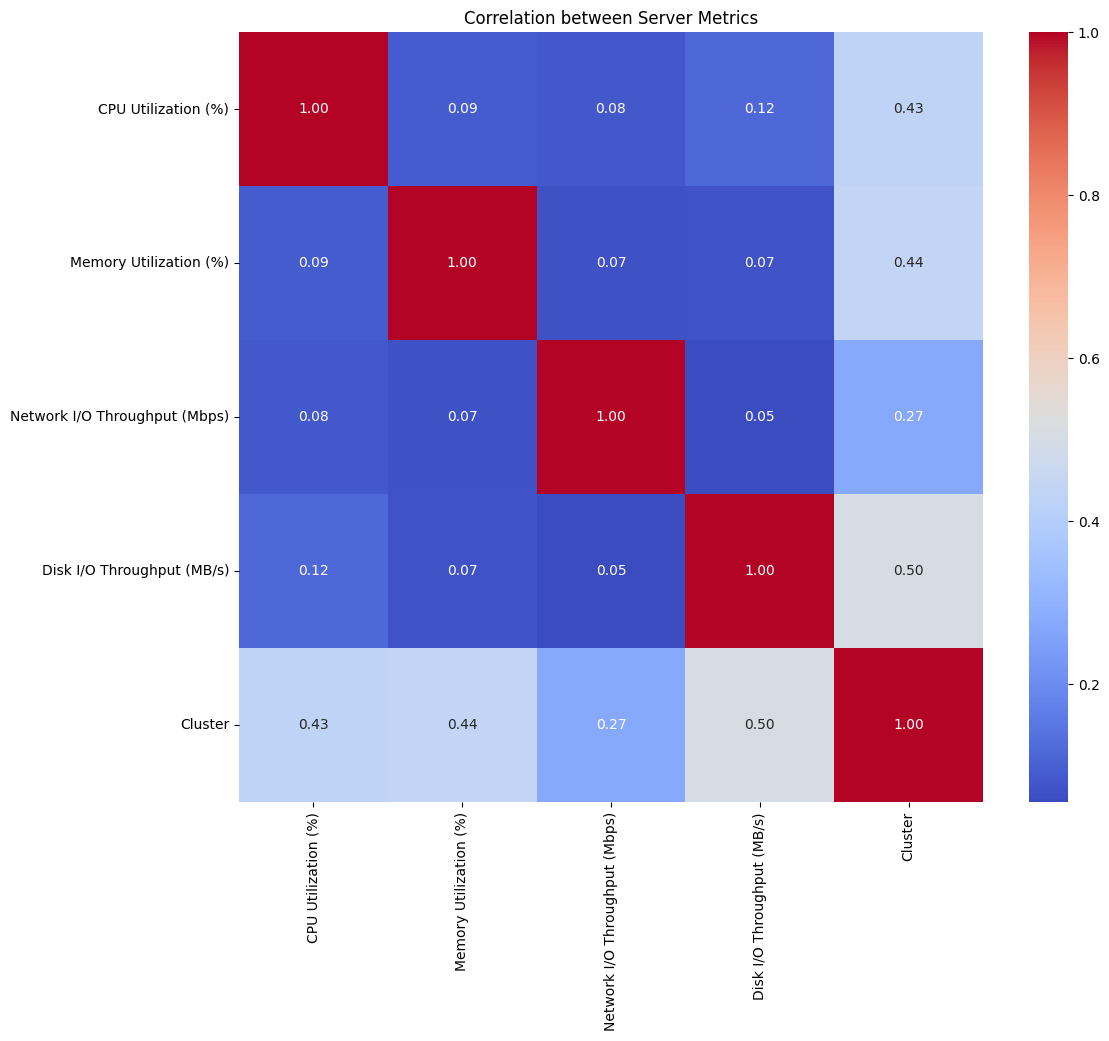

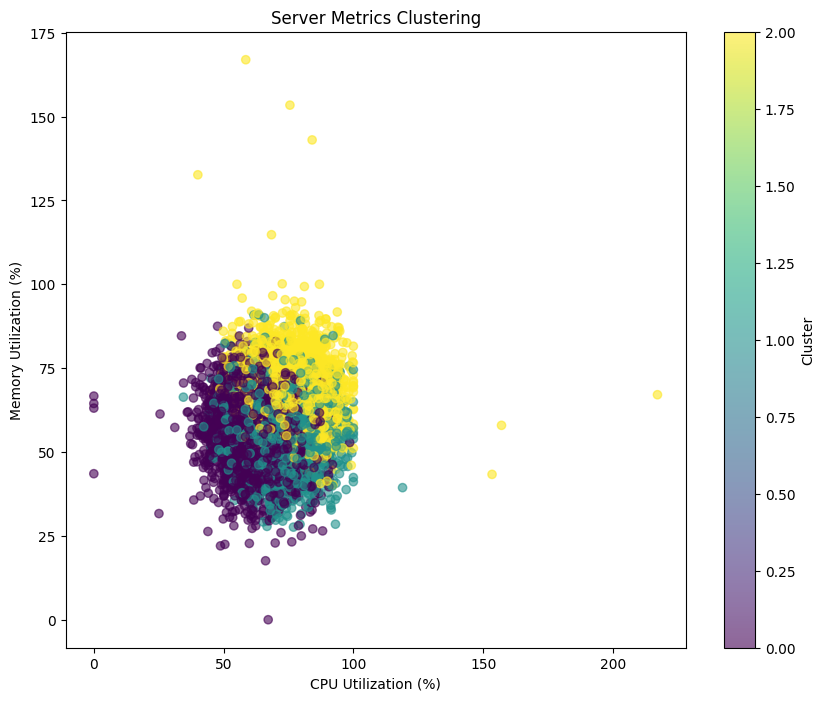

In [118]:
# Step 4: Data Analysis and Insights
# Clustering Analysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Normalize/Scale Data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
server_metrics_scaled = scaler.fit_transform(
    server_metrics.select_dtypes(include="number")
)

# Example: KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
server_clusters = kmeans.fit_predict(server_metrics_scaled)

# Add cluster labels to the original dataframe
server_metrics["Cluster"] = server_clusters

# Calculate silhouette score for evaluating the clustering
silhouette_avg = silhouette_score(server_metrics_scaled, server_clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap of correlations between server metrics
numeric_server_metrics = server_metrics.select_dtypes(include="number")
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_server_metrics.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Server Metrics")
plt.show()

# Scatter plot of clusters for CPU and Memory Utilization
plt.figure(figsize=(10, 8))
plt.scatter(
    server_metrics["CPU Utilization (%)"],
    server_metrics["Memory Utilization (%)"],
    c=server_metrics["Cluster"],
    cmap="viridis",
    alpha=0.6,
)
plt.colorbar(label="Cluster")
plt.xlabel("CPU Utilization (%)")
plt.ylabel("Memory Utilization (%)")
plt.title("Server Metrics Clustering")
plt.show()

# Pair plot for visualizing the clusters across multiple features
sns.pairplot(server_metrics, hue="Cluster", diag_kind="kde", markers=["o", "s", "D"])
plt.suptitle("Pair Plot of Server Metrics by Cluster", y=1.02)
plt.show()

Aligned Data Columns:
Index(['Server Configuration_server', 'CPU Utilization (%)',
       'Memory Utilization (%)', 'Network I/O Throughput (Mbps)',
       'Disk I/O Throughput (MB/s)', 'Cluster',
       'Server Configuration_business', 'Response Time (ms)',
       'Customer Satisfaction (CSAT)', 'Operational Costs ($)',
       'Service Uptime (%)'],
      dtype='object')
Correlation with Business Metrics:
                               CPU Utilization (%)  Memory Utilization (%)  \
CPU Utilization (%)                       1.000000                0.090905   
Memory Utilization (%)                    0.090905                1.000000   
Network I/O Throughput (Mbps)             0.082112                0.068645   
Disk I/O Throughput (MB/s)                0.115724                0.072294   
Response Time (ms)                        0.924106                0.046772   
Customer Satisfaction (CSAT)             -0.370439                0.859422   
Operational Costs ($)                     0.

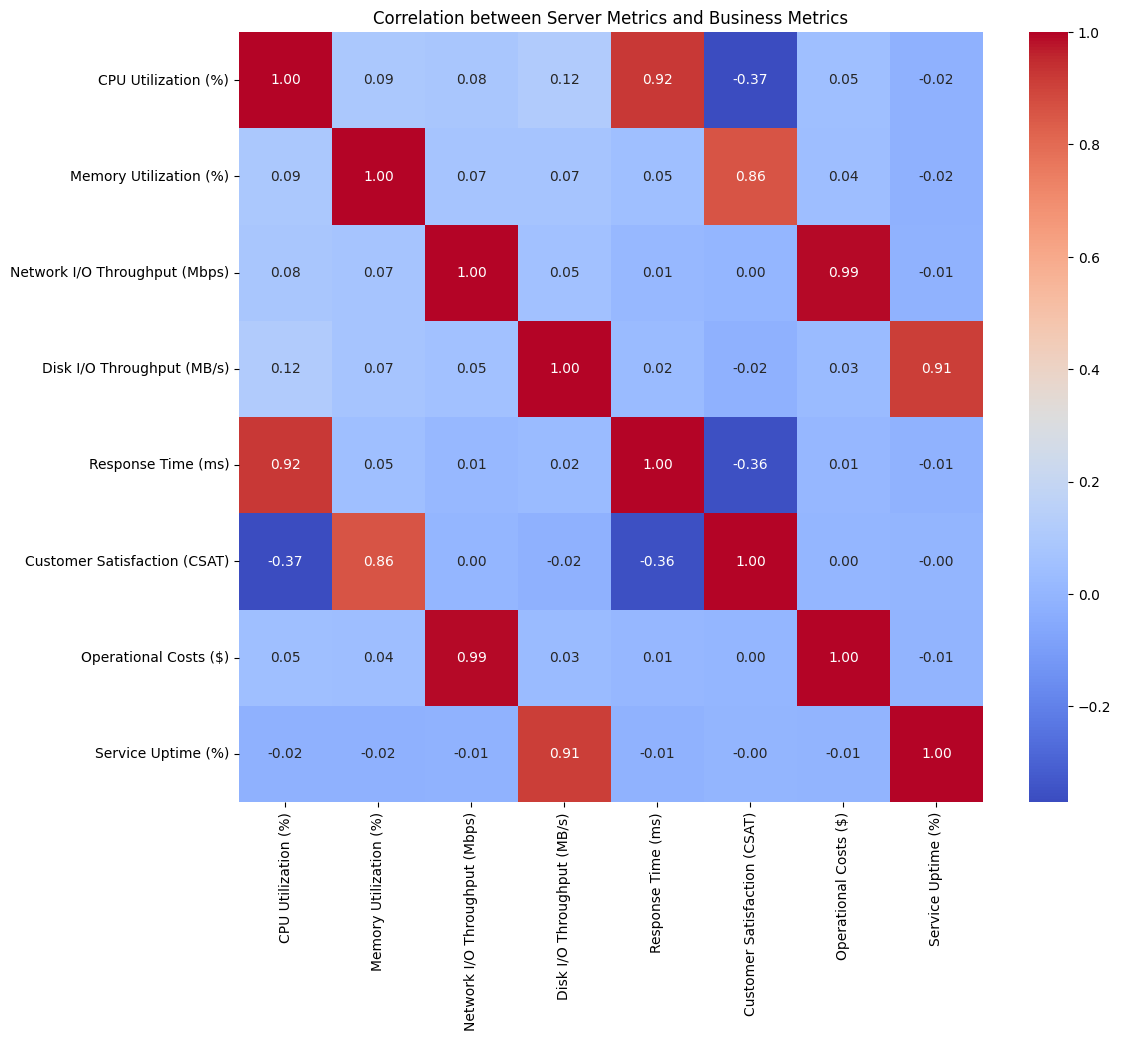

In [ ]:
# Step 5: Business Analysis

# Ensure 'Timestamp' column is present and convert to datetime
if "Timestamp" not in server_metrics.columns:
    raise KeyError("The 'Timestamp' column is missing in the server_metrics DataFrame.")
if "Timestamp" not in business_metrics.columns:
    raise KeyError(
        "The 'Timestamp' column is missing in the business_metrics DataFrame."
    )

server_metrics["Timestamp"] = pd.to_datetime(server_metrics["Timestamp"])
business_metrics["Timestamp"] = pd.to_datetime(business_metrics["Timestamp"])

# Aligning data based on Timestamp
server_metrics.set_index("Timestamp", inplace=True)
business_metrics.set_index("Timestamp", inplace=True)

# Ensure both dataframes are aligned
aligned_data = server_metrics.join(
    business_metrics, how="inner", lsuffix="_server", rsuffix="_business"
)

# Print columns to check names after joining
print("Aligned Data Columns:")
print(aligned_data.columns)

# Check for and drop missing values, if any
aligned_data.dropna(inplace=True)

# Split back into server and business metrics
server_cols = [
    "CPU Utilization (%)",
    "Memory Utilization (%)",
    "Network I/O Throughput (Mbps)",
    "Disk I/O Throughput (MB/s)",
]
business_cols = [
    "Response Time (ms)",
    "Customer Satisfaction (CSAT)",
    "Operational Costs ($)",
    "Service Uptime (%)",
]

numeric_server_metrics = aligned_data[server_cols]
numeric_business_metrics = aligned_data[business_cols]

# Rename columns for easier access
numeric_server_metrics.columns = [
    "CPU Utilization (%)",
    "Memory Utilization (%)",
    "Network I/O Throughput (Mbps)",
    "Disk I/O Throughput (MB/s)",
]
numeric_business_metrics.columns = [
    "Response Time (ms)",
    "Customer Satisfaction (CSAT)",
    "Operational Costs ($)",
    "Service Uptime (%)",
]

# Compute the correlation matrix between server metrics and business metrics
correlation_matrix = numeric_server_metrics.join(numeric_business_metrics).corr()
print("Correlation with Business Metrics:")
print(correlation_matrix)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap of correlations between server metrics and business metrics
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Server Metrics and Business Metrics")
plt.show()

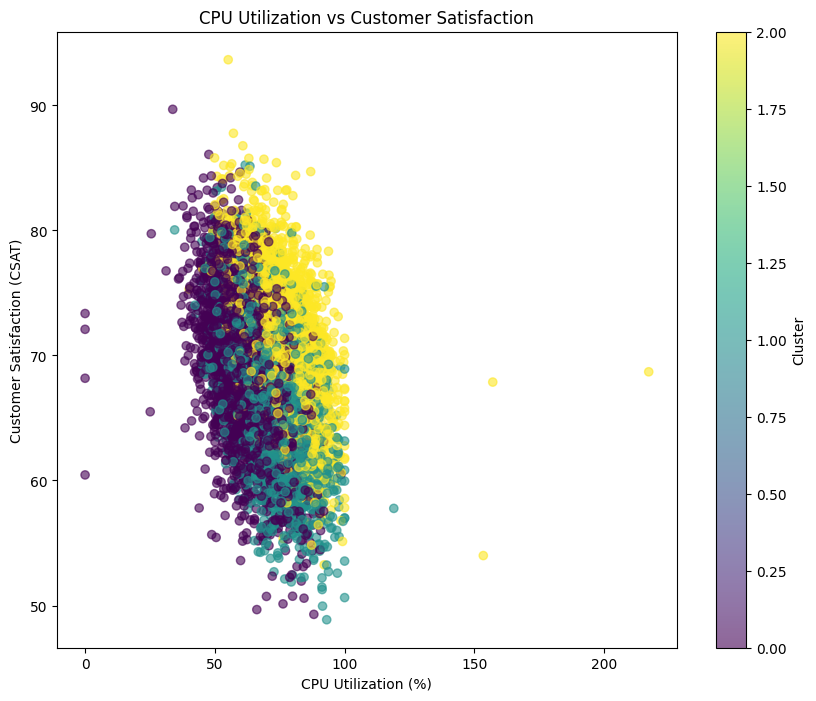

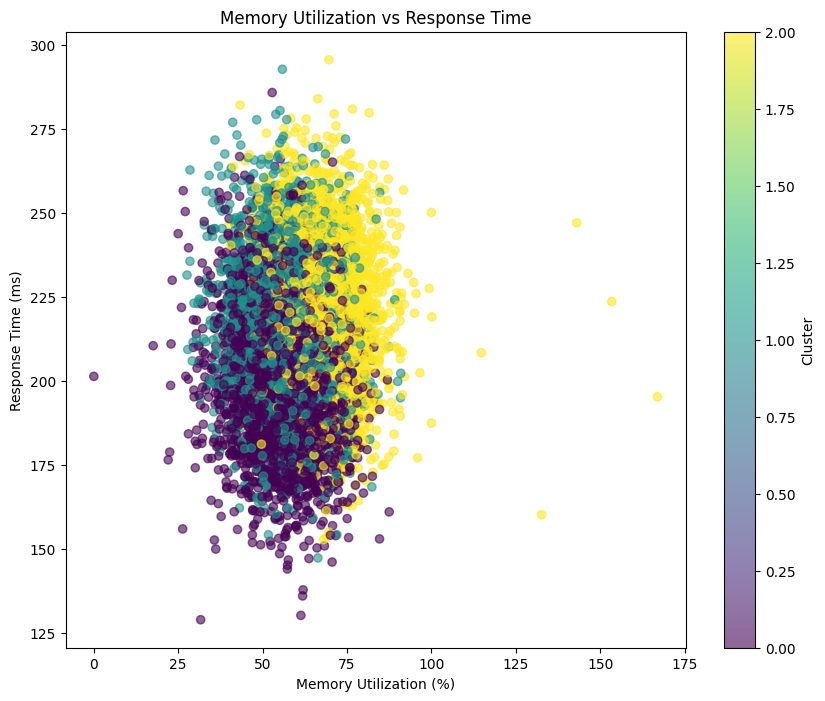

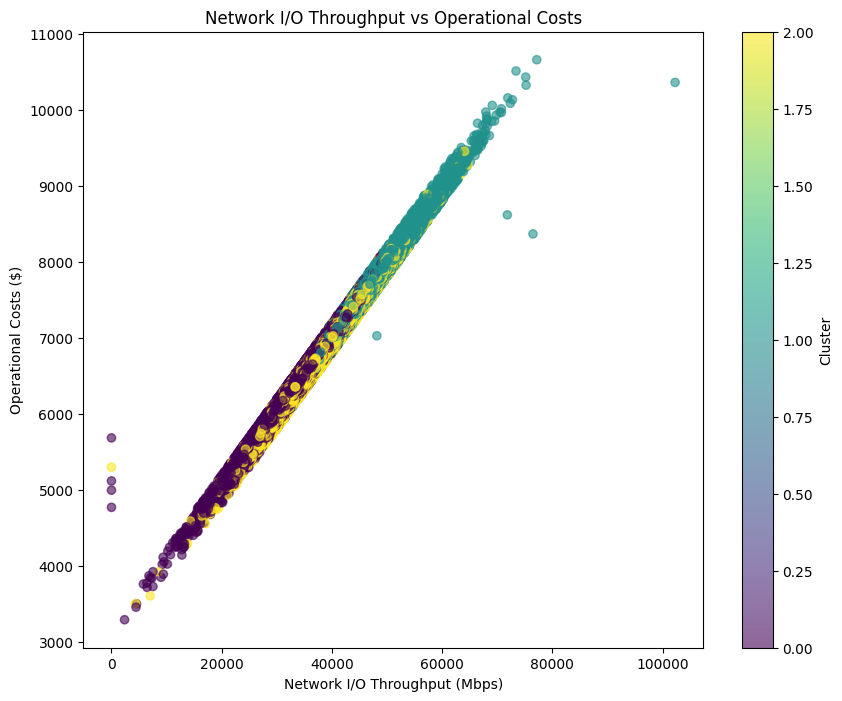

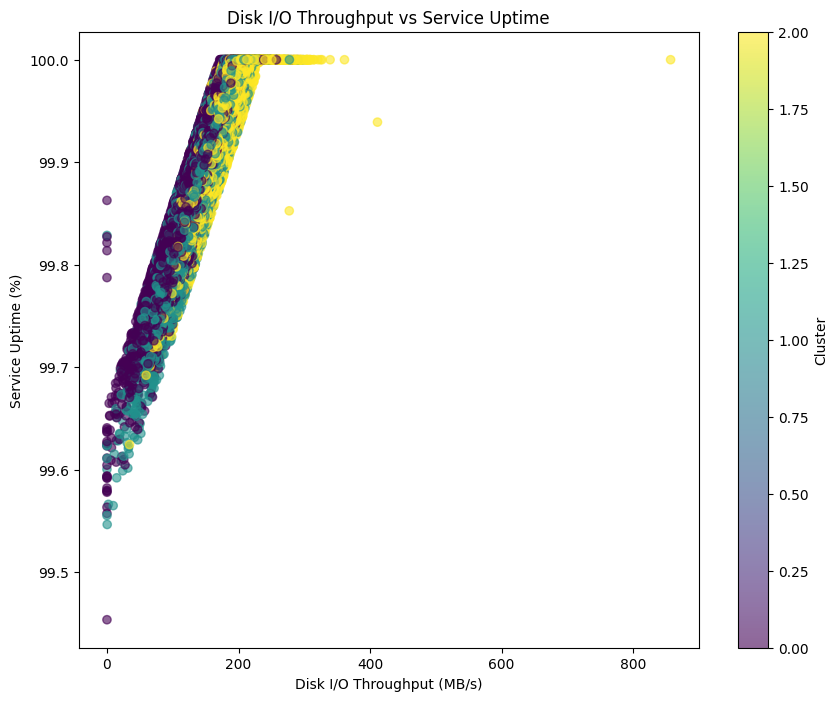


Insights:
CPU Utilization (%) and Customer Satisfaction (CSAT): -0.37
Memory Utilization (%) and Response Time (ms): 0.05
Network I/O Throughput (Mbps) and Operational Costs ($): 0.99
Disk I/O Throughput (MB/s) and Service Uptime (%): 0.91

Interpretation of Insights:
A weak correlation of -0.37 between CPU Utilization (%) and Customer Satisfaction (CSAT) suggests that changes in CPU Utilization (%) have little impact on Customer Satisfaction (CSAT).
A weak correlation of 0.05 between Memory Utilization (%) and Response Time (ms) suggests that changes in Memory Utilization (%) have little impact on Response Time (ms).
A strong positive correlation of 0.99 between Network I/O Throughput (Mbps) and Operational Costs ($) suggests that as Network I/O Throughput (Mbps) increases, Operational Costs ($) also increases.
A strong positive correlation of 0.91 between Disk I/O Throughput (MB/s) and Service Uptime (%) suggests that as Disk I/O Throughput (MB/s) increases, Service Uptime (%) also 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 6: Optimization Recommendations & Business Insights


# Scatter plot function
def plot_scatter(x, y, clusters, xlabel, ylabel, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(x, y, c=clusters, cmap="viridis", alpha=0.6)
    plt.colorbar(label="Cluster")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


# Assuming aligned_data and correlation_matrix are defined appropriately

# Define scatter plots with feature pairs and titles
scatter_plots = [
    (
        "CPU Utilization (%)",
        "Customer Satisfaction (CSAT)",
        "CPU Utilization vs Customer Satisfaction",
    ),
    (
        "Memory Utilization (%)",
        "Response Time (ms)",
        "Memory Utilization vs Response Time",
    ),
    (
        "Network I/O Throughput (Mbps)",
        "Operational Costs ($)",
        "Network I/O Throughput vs Operational Costs",
    ),
    (
        "Disk I/O Throughput (MB/s)",
        "Service Uptime (%)",
        "Disk I/O Throughput vs Service Uptime",
    ),
]

# Generate Scatter Plots
for x_feature, y_feature, plot_title in scatter_plots:
    plot_scatter(
        aligned_data[x_feature],
        aligned_data[y_feature],
        aligned_data["Cluster"],
        x_feature,
        y_feature,
        plot_title,
    )

# Generate Insights dynamically
insights = {}
for x_feature, y_feature, _ in scatter_plots:
    correlation = correlation_matrix.loc[x_feature, y_feature]
    insights[f"{x_feature} and {y_feature}"] = correlation

print("\nInsights:")
for k, v in insights.items():
    print(f"{k}: {v:.2f}")


#  Automated Insights Interpretation
def interpret_insights(insights):
    for key, correlation in insights.items():
        feature1, feature2 = key.split(" and ")
        if correlation > 0.5:
            print(
                f"A strong positive correlation of {correlation:.2f} between {feature1} and {feature2} suggests that as {feature1} increases, {feature2} also increases."
            )
        elif correlation < -0.5:
            print(
                f"A strong negative correlation of {correlation:.2f} between {feature1} and {feature2} suggests that as {feature1} increases, {feature2} decreases."
            )
        else:
            print(
                f"A weak correlation of {correlation:.2f} between {feature1} and {feature2} suggests that changes in {feature1} have little impact on {feature2}."
            )


print("\nInterpretation of Insights:")
interpret_insights(insights)


# Optimization Recommendations
def optimization_recommendations(insights):
    recommendations = []
    for key, correlation in insights.items():
        feature1, feature2 = key.split(" and ")
        if correlation > 0.5:
            recommendations.append(
                f"Consider optimizing {feature1} to improve {feature2}."
            )
        elif correlation < -0.5:
            recommendations.append(
                f"Consider optimizing {feature1} to reduce {feature2}."
            )
    return recommendations


print("\nOptimization Recommendations:")
for recommendation in optimization_recommendations(insights):
    print(f"- {recommendation}")
